# Meteogram

In this example we describe how to plot the hourly evolution of 2-m temperature and precipitation for a given place.

In [ ]:
# We import the necessary libraries
import xarray as xr
import h5netcdf
import datetime
import s3fs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

We define the forecast initialization date, latitude and longitude of interest:

In [ ]:
latitude = -40
longitude = -50

start_year = 2022
start_month = 3
start_day = 21
start_hour = 0

We read the forecast:

In [ ]:
START_DATE = datetime.datetime(start_year, start_month, start_day, start_hour)

fs = s3fs.S3FileSystem(anon=True)

files = fs.glob(f'smn-ar-wrf/DATA/WRF/DET/{FECHA_INI:%Y/%m/%d/%H}/WRFDETAR_01H_{START_DATE:%Y%m%d_%H}_*.nc')

ds_list = []
for s3_file in files:
    print(s3_file)
    f = fs.open(s3_file)
    ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
    ds_list.append(ds_tmp)

ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')

We get the appropriate forecast value:

In [ ]:
# Searching the closest gridpoint to the selected lat-lon 
data_crs = ccrs.LambertConformal(central_longitude = ds.CEN_LON, 
                                 central_latitude = ds.CEN_LAT, 
                                 standard_parallels = (ds.TRUELAT1, ds.TRUELAT2))
x, y = data_crs.transform_point(longitude, latitude, src_crs=ccrs.PlateCarree())

# Extraction of the value at the chosen gridpoint
forecast = ds.sel(dict(x = x, y = y), method = 'nearest')

# Obtention of time series for the 2-m temperature, accumulated precipitation and dates 
T2 = forecast['T2']
PP = forecast['PP']
dates = forecast['time']

We create the plot:

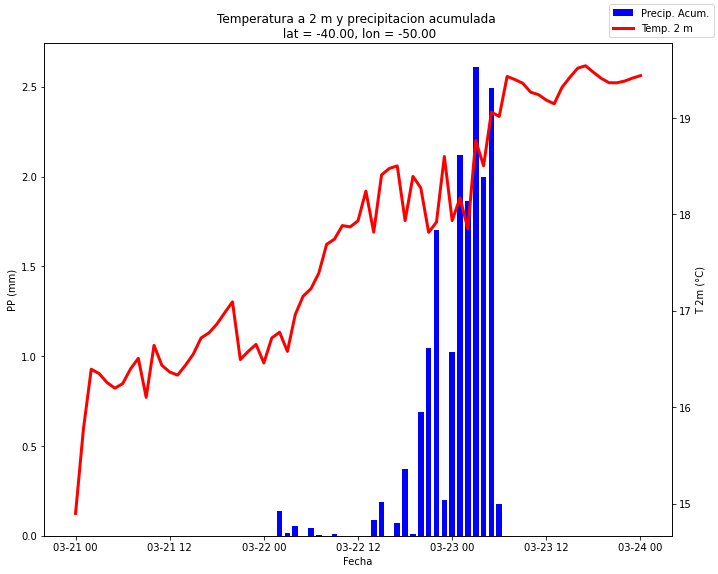

In [ ]:
# Plotting begins
fig, ax = plt.subplots(figsize = (10, 8))
# Doubling x axis
ax2 = ax.twinx()
# Choosing bar diagram for precipitation 
ax.bar(dates, PP, color = 'blue', width = 0.03, label = 'Precip. Acum.')
# Choosing simple lines for temperature
ax2.plot(dates, T2, color = 'red', label = 'Temp. 2 m', linewidth = 3)
# Defining labels in the axes 
ax.set_xlabel('Date')
ax2.set_ylabel('T 2m (Â°C)')
ax.set_ylabel('PP (mm)')
# Defining title of figure 
plt.title(f'2-m temperature and accumulated precipitation at \n lat = {latitude:0.2f}, lon = {longitude:0.2f}')
# Locating color legend in the upper right corner 
fig.legend(loc = 'upper right')
# Adjusting graphic size
plt.tight_layout()